<img src="images/oil.png" alt="Local Image" style="width: 100%;">

# Analyzing the Impact of OPEC Crude Oil Production Quotas

#### Will Rodman | Tulane University | Data Science | November 10th, 2023
#### Project Link: https://willcrodman.github.io

## Project Outline

This project will analyze the impact of **OPEC** (Organization of the Petroleum Exporting Countries) crude oil production quotas on the oil markets of both OPEC and **OECD** (Organization for Economic Co-operation and Development) countries from 1983 to 2022. Including providing political context of OPEC and OECD, exploring their respective roles and significance in the global oil trade. The data source for this project is from the official OPEC website, which includes data such as crude oil production, demand, spot prices, refinery throughput, and capacity by country.

Founded in 1960, OPEC comprises a group of petroleum-exporting nations. OPEC was created with the primary aim of asserting collective control over their oil resources and global oil trade. OPEC's founding members included Iran, Iraq, Kuwait, Saudi Arabia, and Venezuela. Over the years, the organization has expanded to include several other member nations, totaling 13.

This project places a unique focus on OPEC member nations due to their global importance as petroleum exporters. Alongside OECD countries, who are reliant on oil imports to meet their energy needs, and have historically been affected by changes in OPEC production quotas and embargoes.

#### Data Source: https://asb.opec.org/data/ASB_Data.php


In [1]:
# Installing library requirements.
!pip install pandas numpy --quiet

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [2]:
# Import library requirements.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

<img src="images/opec.png" alt="Local Image" style="width: 50%;">

## OPEC and OCED Countries

While OPEC consists of major oil-producing nations such as Saudi Arabia, Iran, Iraq, and Venezuela, among others. OECD comprises economically advanced nations, primarily in Europe and North America, which heavily rely on oil imports to fulfill their energy requirements. Currently there are 38 member countries in OECD including the United States and United Kingdom. 

In [3]:
# List of OPEC countries in 2023. 
opec_countries = pd.read_csv('data/countries/opec.csv', header=None, squeeze=True)
opec_countries.head(13)

/var/folders/rq/9zvkr67d2mx07n6md37__xcr0000gn/T/ipykernel_2731/3424938140.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  opec_countries = pd.read_csv('data/countries/opec.csv', header=None, squeeze=True)


0                  Algeria
1                   Angola
2        Equatorial Guinea
3                    Gabon
4                 I.R.Iran
5                     Iraq
6                   Kuwait
7                    Libya
8                  Nigeria
9                    Congo
10            Saudi Arabia
11    United Arab Emirates
12               Venezuela
Name: 0, dtype: object

In [4]:
# List of OECD countries in 2023. 
oecd_countries = pd.read_csv('data/countries/oecd.csv', header=None, squeeze=True)
oecd_countries.head()

/var/folders/rq/9zvkr67d2mx07n6md37__xcr0000gn/T/ipykernel_2731/556852201.py:2: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  oecd_countries = pd.read_csv('data/countries/oecd.csv', header=None, squeeze=True)


0    Australia
1      Austria
2      Belgium
3       Canada
4        Chile
Name: 0, dtype: object

## Crude Oil Production and Demand

### Extract, Transform, and Load (ETL) Data

This imports crude oil production and demand for countries world wide (including all OPEC members) from 1960 to 2020. **Crude Oil** refers to the fossil fuel that exits in Earths geological formations.  They will be stored in the project as Pandas DataFrames, along with a third DataFrame that describes countries domestic crude oil demand deficits per year. 

$\text{Deficit}_{\text{year}} = \text{Production}_{\text{year}} - \text{Consumption}_{\text{year}}$





In [21]:
# Importing oil production dataset.
oil_production_df = pd.read_csv("data/opec_upstream/world_oil_production.csv", index_col="Index")
oil_production_df.replace('na', np.nan, inplace=True)
oil_production_df = oil_production_df.astype(float)

# Replacing incorrectly labeled countries. 
replace = {'IR Iran': 'I.R.Iran', 'Saudi Arabia1': 'Saudi Arabia', 'Kuwait1': 'Kuwait', 'Syrian Arab Rep.': 'Syria', 'Uzbekistan`': 'Uzbekistan'}
oil_production_df = oil_production_df.rename(index=replace)

# Importing oil demand dataset. 
oil_demand_df = pd.read_csv("data/opec_downstream/world_oil_demand.csv", index_col="Index")
oil_demand_df.replace('na', np.nan, inplace=True)
oil_demand_df = oil_demand_df.astype(float)

# Merging oil production and oil demand datasets; One-to-one matching needed to compute oil deficit. 
oil_deficit_df = oil_demand_df.merge(oil_production_df, left_index=True, right_index=True, how='inner')

# Iterating over years of oil production and oil demand to compute oil deficit. 
for year in range(1960, 2023):
    year_x, year_y = f"{year}_x", f"{year}_y"
    oil_deficit_df[year] = oil_deficit_df[year_x] - oil_deficit_df[year_y]
    oil_deficit_df = oil_deficit_df.drop(columns=[year_x, year_y])
    
# Transposing DataFrames to set years as index.  
oil_production_df = oil_production_df.transpose()
oil_demand_df = oil_demand_df.transpose()
oil_deficit_df = oil_deficit_df.transpose()

# Converting year index to datetime object. 
oil_production_df.index = pd.to_datetime(oil_production_df.index, format='%Y')
oil_demand_df.index = pd.to_datetime(oil_demand_df.index, format='%Y')
oil_deficit_df.index = pd.to_datetime(oil_deficit_df.index, format='%Y')

# Filter the DataFrames to include data only within 1983 - 2022. 
oil_production_df = oil_production_df.loc['1983':'2022']
oil_demand_df = oil_demand_df.loc['1983':'2022']
oil_deficit_df = oil_deficit_df.loc['1983':'2022']

# Display DataFrame
oil_deficit_df.head() 


Because our two datasets do not have a perfect one-to-one matching, deficits cannot be computed for every country. This mean exploratory data analysis will be for all OPEC member countries and a limited number of OECD member countries. 

In [26]:
print('Countries in oil production DataFrame:', len(oil_production_df.columns))
print('Countries in oil demand DataFrame:', len(oil_demand_df.columns))
print('Countries in oil deficit DataFrame:', len(oil_deficit_df.columns))

Countries in oil production DataFrame: 48
Countries in oil demand DataFrame: 61
Countries in oil deficit DataFrame: 37


### Exploratory Data Analysis (EDA)

This analysis visualized production demand over time using a line plot and box plot, visualization are categorized by: 
1. The top five oil producers in 2023. 
2. OPEC member countries. 
3. OECD member countries with accessible data. 

#### Box Plot Distribution
<img src="images/box.png" alt="Local Image" style="width: 25%;">


In [35]:
# Function graphs oil production, oil demand and oil deficit for a given list of countries. 
def line_plot_production(cols, title=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

    oil_production_df[cols].plot(kind='line', legend=False, ax=ax1)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Crude Oil (1000 barrels/day)')
    ax1.set_title('Domestic Production')

    oil_demand_df[cols].plot(kind='line', legend=False, ax=ax2)
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Crude Oil (1000 barrels/day)')
    ax2.set_title('Domestic Demand')

    oil_deficit_df[cols].plot(kind='line', legend=False, ax=ax3)
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Crude Oil (1000 barrels/day)')
    ax3.set_title('Domestic Deficit')
    ax3.axhline(y=0, color='black', linestyle='--')

    lines, labels = ax1.get_legend_handles_labels()
    fig.legend(lines, labels, loc='center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    fig.suptitle(title, fontsize=20, y=1.02)
    plt.tight_layout()
    
# Function plots the distributions of oil production, oil demand and oil deficit for a given list of countries. 
def box_plot_production(cols, title=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

    # Generating x-axis labels. 
    x_labels = list(oil_production_df.index.year)
    x_labels = [label if i % 5 == 0 else '' for i, label in enumerate(x_labels)]
    
    oil_production_df[cols].transpose().boxplot(ax=ax1, showfliers=False)
    ax1.set_title('Domestic Production')
    ax1.set_ylabel('Crude Oil (1000 barrels/day)')
    ax1.grid(False, axis='x')
    ax1.set_xticklabels(x_labels)
    ax1.set_ylim(0, 5000)

    oil_demand_df[cols].transpose().boxplot(ax=ax2, showfliers=False)
    ax2.set_title('Domestic Demand')
    ax2.set_ylabel('Crude Oil (1000 barrels/day)')
    ax2.grid(False, axis='x')
    ax2.set_xticklabels(x_labels)
    ax2.set_ylim(0, 5000)

    oil_deficit_df[cols].transpose().boxplot(ax=ax3, showfliers=False)  
    ax3.set_title('Domestic Deficit')
    ax3.set_ylabel('Crude Oil (1000 barrels/day)')
    ax3.axhline(y=0, color='red', linestyle='--')
    ax3.grid(False, axis='x')
    ax3.set_xticklabels(x_labels)

    fig.suptitle(title, fontsize=20, y=1.02)
    plt.tight_layout()

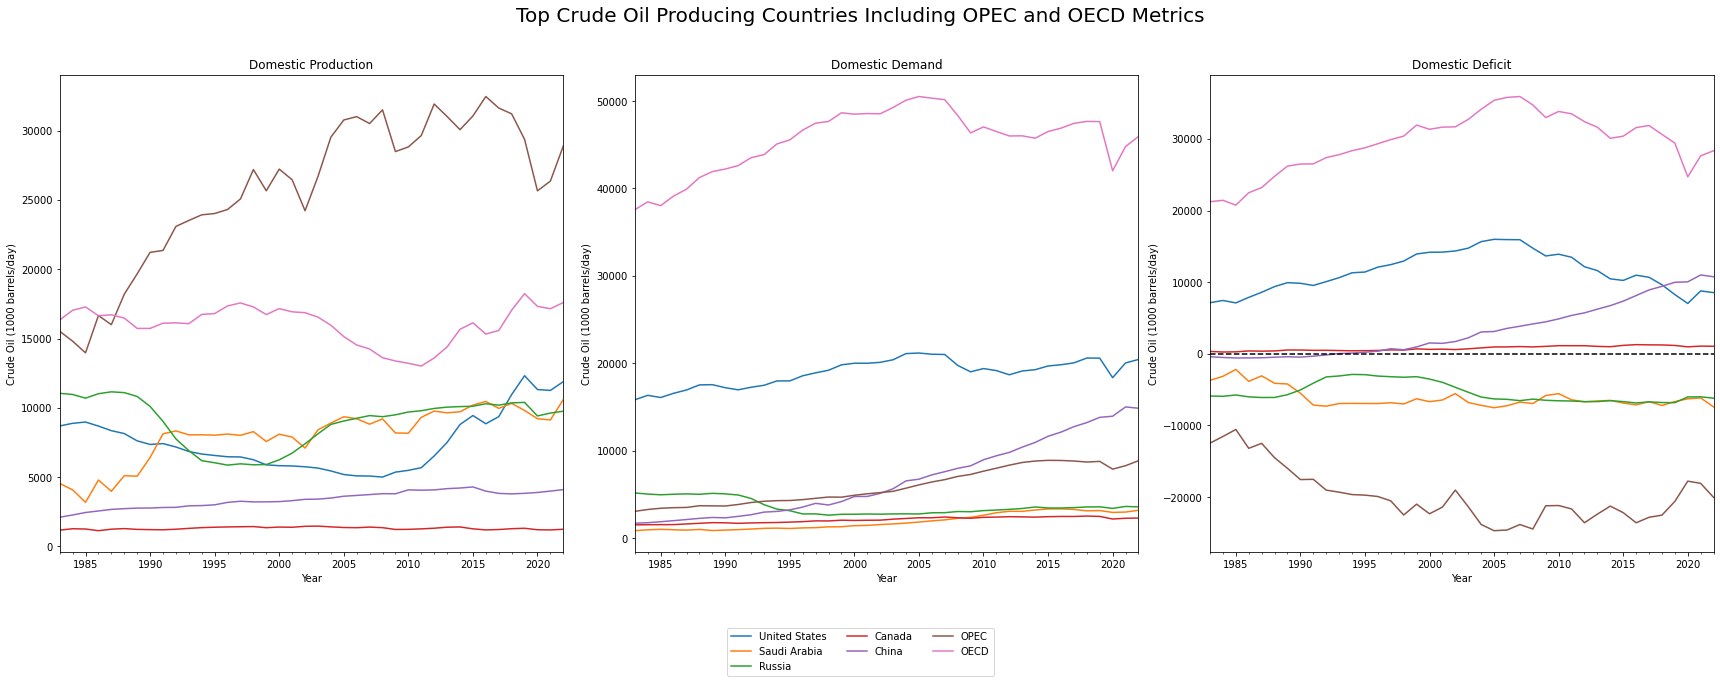

In [68]:
top_oil_producing_countries = ["United States", "Saudi Arabia", "Russia", "Canada", "China", "OPEC", "OECD"]
line_plot_production(top_oil_producing_countries, title="Top Crude Oil Producing Countries Including OPEC and OECD Metrics")

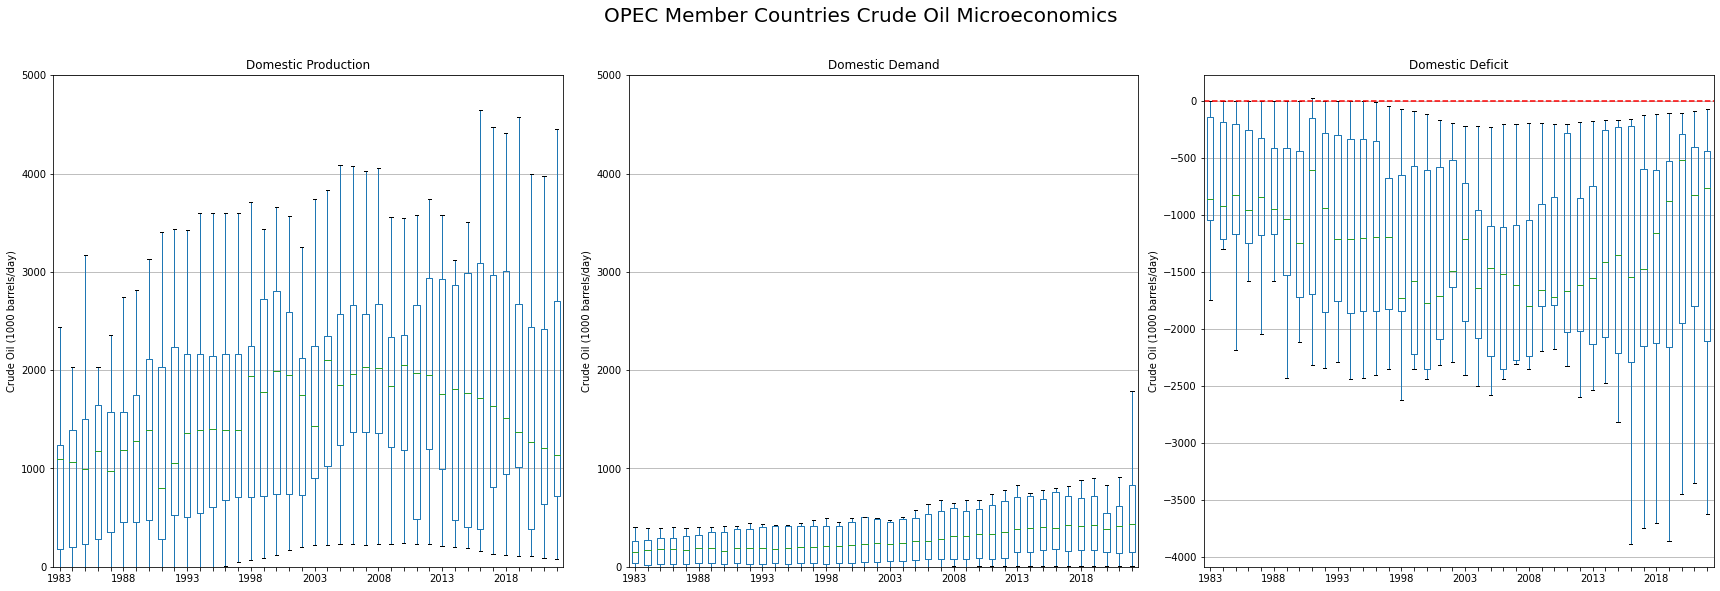

In [51]:
box_plot_production(opec_countries, title="OPEC Member Countries Crude Oil Metrics")

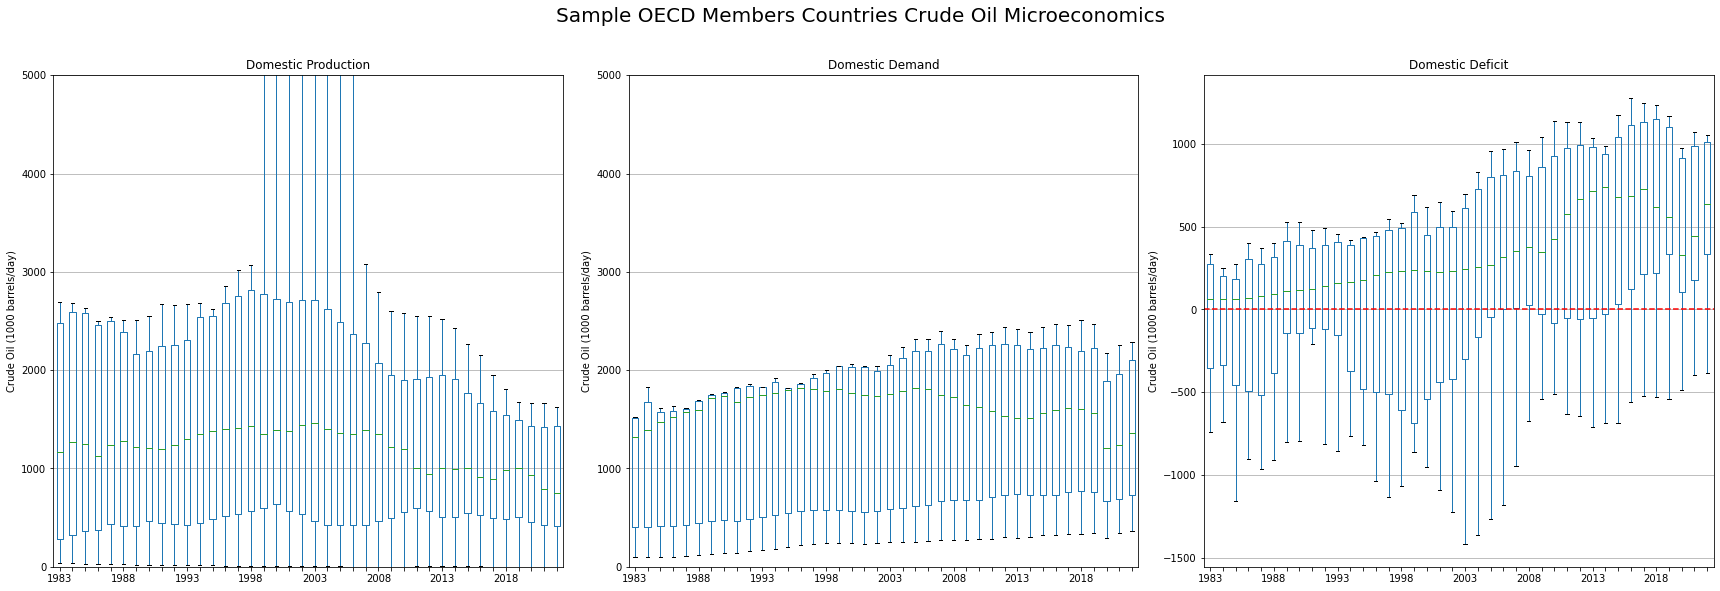

In [52]:
# Collecting OECD countries with accessible data. 
oecd_sample_countries = oecd_countries[oecd_countries.isin(oil_deficit_df.columns)]
box_plot_production(oecd_sample_countries, "Sample OECD Members Countries Crude Oil Metrics")

The visualization show how OPEC countries have a negative crude oil deficit, while the median sample of OECD have a positive crude oil deficit. It is also show how large economies United States (OECD member) Canada (OECD member), Saudi Arabia (OPEC member) and Russia (OEPC+ member) can influence the distributions. 

## Oil Refinery Load and Capacity 

### Extract, Transform, and Load (ETL) Data

This imports crude oil refinery utilization and capacities for countries world wide (including all OPEC members) from 1980 to 2022. A **Oil Refinery** processes crude oil into various refined products, including gasoline, diesel, and petrochemicals. They will be stored in the project as Pandas DataFrames, along with a third DataFrame that describes countries utilization rates of oil refineries per year. 

$\text{Utilization}_{\text{year}} = \left(1 - \frac{ \text{Refinery Capacity}_{\text{year}} - \text{Refinery Throughput}_{\text{year}}}{\text{Refinery Capacity}_{\text{year}}}\right) \times 100$


In [54]:
# Importing oil production dataset.
refinery_capacity_df = pd.read_csv("data/opec_downstream/world_refinery_capacity.csv", index_col="Index")
refinery_capacity_df.replace('na', np.nan, inplace=True)
refinery_capacity_df.replace('n.a.', np.nan, inplace=True)
refinery_capacity_df = refinery_capacity_df.astype(float)

# Replacing incorrectly labeled countries. 
replace = {'United States2': 'United States',
        'South Korea2': 'South Korea',
        'Venezuela3': 'Venezuela',
        'I.R.Iran2': 'I.R.Iran',
        'Qatar2': 'Qatar',
        'Saudi Arabia2': 'Saudi Arabia',
        'United Arab Emirates2': 'United Arab Emirates',
        'Algeria2': 'Algeria'
        }
refinery_capacity_df = refinery_capacity_df.rename(index=replace)


# Importing oil demand dataset. 
refinery_throughput_df = pd.read_csv("data/opec_downstream/world_refinery_throughput.csv", index_col="Index")
refinery_throughput_df.replace('na', np.nan, inplace=True)
refinery_throughput_df.replace('n.a.', np.nan, inplace=True)
refinery_throughput_df = refinery_throughput_df.astype(float)

# Merging oil production and oil demand datasets; One-to-one matching needed to compute oil deficit. 
refinery_utilization_df = refinery_capacity_df.merge(refinery_throughput_df, left_index=True, right_index=True, how='inner')

# Iterating over years of oil production and oil demand to compute oil deficit. 
for year in range(1980, 2023):
    year_x, year_y = f"{year}_x", f"{year}_y"
    refinery_utilization_df[year] = (1 - (refinery_utilization_df[year_x] - refinery_utilization_df[year_y]) / refinery_utilization_df[year_x]) * 100
    refinery_utilization_df = refinery_utilization_df.drop(columns=[year_x, year_y])
    
# Transposing DataFrames to set years as index.  
refinery_capacity_df = refinery_capacity_df.transpose()
refinery_throughput_df = refinery_throughput_df.transpose()
refinery_utilization_df = refinery_utilization_df.transpose()

# Converting year index to datetime object. 
refinery_capacity_df.index = pd.to_datetime(refinery_capacity_df.index, format='%Y')
refinery_throughput_df.index = pd.to_datetime(refinery_throughput_df.index, format='%Y')
refinery_utilization_df.index = pd.to_datetime(refinery_utilization_df.index, format='%Y')

# Filter the DataFrames to include data only within 1983 - 2022. 
refinery_capacity_df = refinery_capacity_df.loc['1983':'2022']
refinery_throughput_df = refinery_throughput_df.loc['1983':'2022']
refinery_utilization_df = refinery_utilization_df.loc['1983':'2022']

# Display. 
refinery_utilization_df.head()

Index,Algeria,Angola,Argentina,Australia,Azerbaijan,Belarus,Belgium,Brazil,Bulgaria,Canada,...,Spain,Thailand,Turkey,Turkmenistan,Ukraine,United Arab Emirates,United Kingdom,United States,Venezuela,Vietnam
1983-01-01,80.220713,80.996885,66.174298,69.655172,55.694444,98.589744,63.911846,70.522648,90.974729,79.696492,...,63.837375,92.090395,70.171674,59.754434,81.515855,61.111111,66.963403,73.073110,69.128575,NaN
1984-01-01,87.224109,87.227414,63.958641,70.124481,55.555556,98.461538,76.441516,74.912892,92.779783,78.809417,...,63.483965,89.265537,80.042918,59.754434,78.267595,78.888889,72.120896,77.624521,66.706329,NaN
1985-01-01,86.587436,87.227414,62.038405,73.880597,55.833333,98.974359,71.880492,75.609756,91.335740,77.182689,...,68.216463,97.590361,79.399142,60.340262,84.068059,91.666667,74.195279,78.686934,71.168290,NaN
1986-01-01,92.105263,87.227414,58.641064,73.141123,56.666667,101.025641,87.520525,80.418118,91.335740,79.943047,...,74.390244,96.089385,68.566494,60.926089,77.416860,93.333333,77.340720,82.376365,71.168290,NaN
1987-01-01,87.436333,90.342679,57.437408,74.497682,57.222222,102.307692,81.804734,82.369338,88.086643,78.455454,...,71.036585,98.882682,67.709815,61.511917,73.549884,92.777778,76.741635,81.677136,63.359857,NaN


In [55]:
print('Countries in oil refinery throughput DataFrame:', len(refinery_throughput_df.columns))
print('Countries in oil refinery capacity:', len(refinery_capacity_df.columns))
print('Countries in oil refinery utilization:', len(refinery_utilization_df.columns))

Countries in oil refinery throughput DataFrame: 76
Countries in oil refinery capacity: 56
Countries in oil refinery utilization: 56


In [56]:
# Function plots refinery data.
def box_plot_refinery(cols, title=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

    # Generating x-axis labels. 
    x_labels = list(oil_production_df.index.year)
    x_labels = [label if i % 5 == 0 else '' for i, label in enumerate(x_labels)]
    
    refinery_throughput_df[cols].transpose().boxplot(ax=ax1, showfliers=False)
    ax1.set_title('Total Throughput')
    ax1.set_ylabel('Crude Oil (1000 barrels/day)')
    ax1.grid(False, axis='x')
    ax1.set_xticklabels(x_labels)
    ax1.set_ylim(0, 4000)

    refinery_capacity_df[cols].transpose().boxplot(ax=ax2, showfliers=False)
    ax2.set_title('Total Capacity')
    ax2.set_ylabel('Crude Oil (1000 barrels/day)')
    ax2.grid(False, axis='x')
    ax2.set_xticklabels(x_labels)
    ax2.set_ylim(0, 4000)

    refinery_utilization_df[cols].transpose().boxplot(ax=ax3, showfliers=False)  
    ax3.set_title('Utilization')
    ax3.set_ylabel('Rate (%)')
    ax3.grid(False, axis='x')
    ax3.set_xticklabels(x_labels)
    ax3.set_ylim(0, 100)


    fig.suptitle(title, fontsize=20, y=1.02)
    plt.tight_layout()

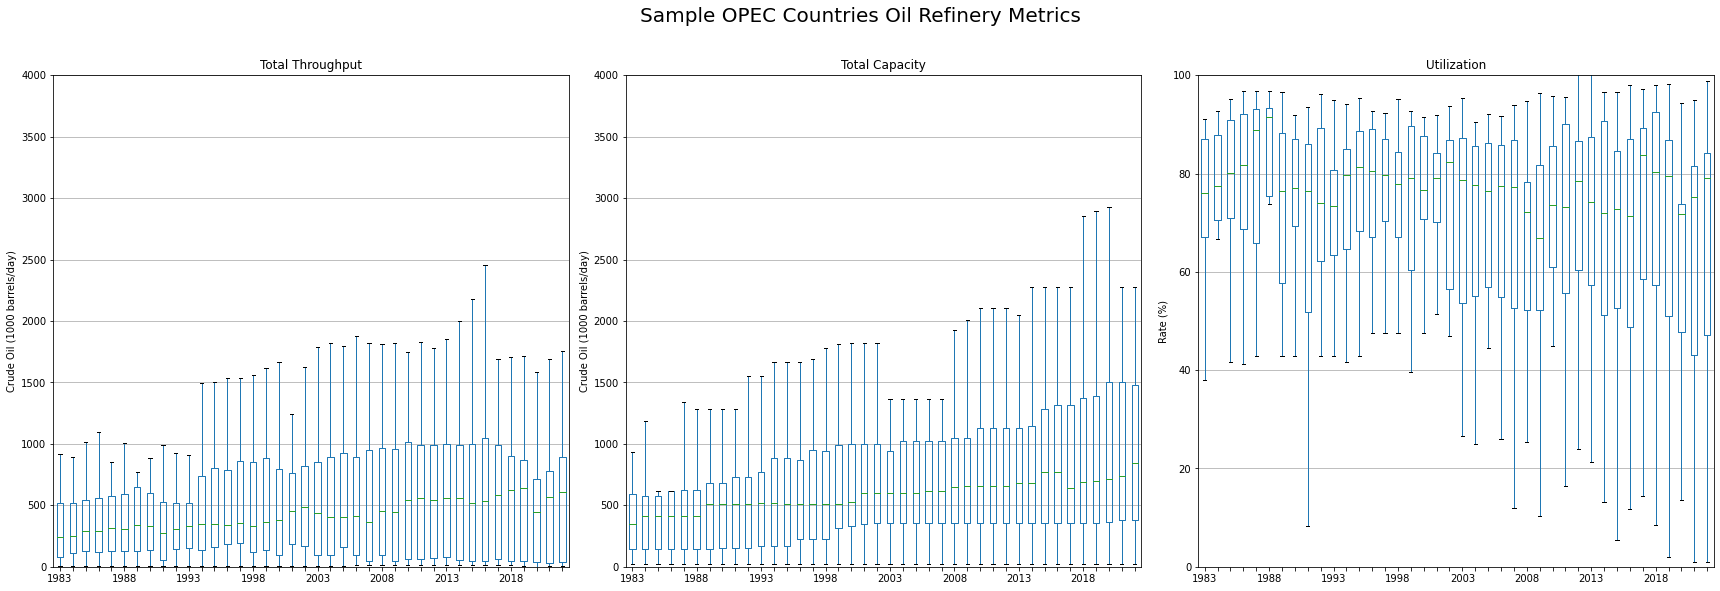

In [57]:
opec_sample_countries = opec_countries[opec_countries.isin(refinery_utilization_df.columns)]
box_plot_refinery(opec_sample_countries, title="Sample OPEC Countries Oil Refinery Metrics")

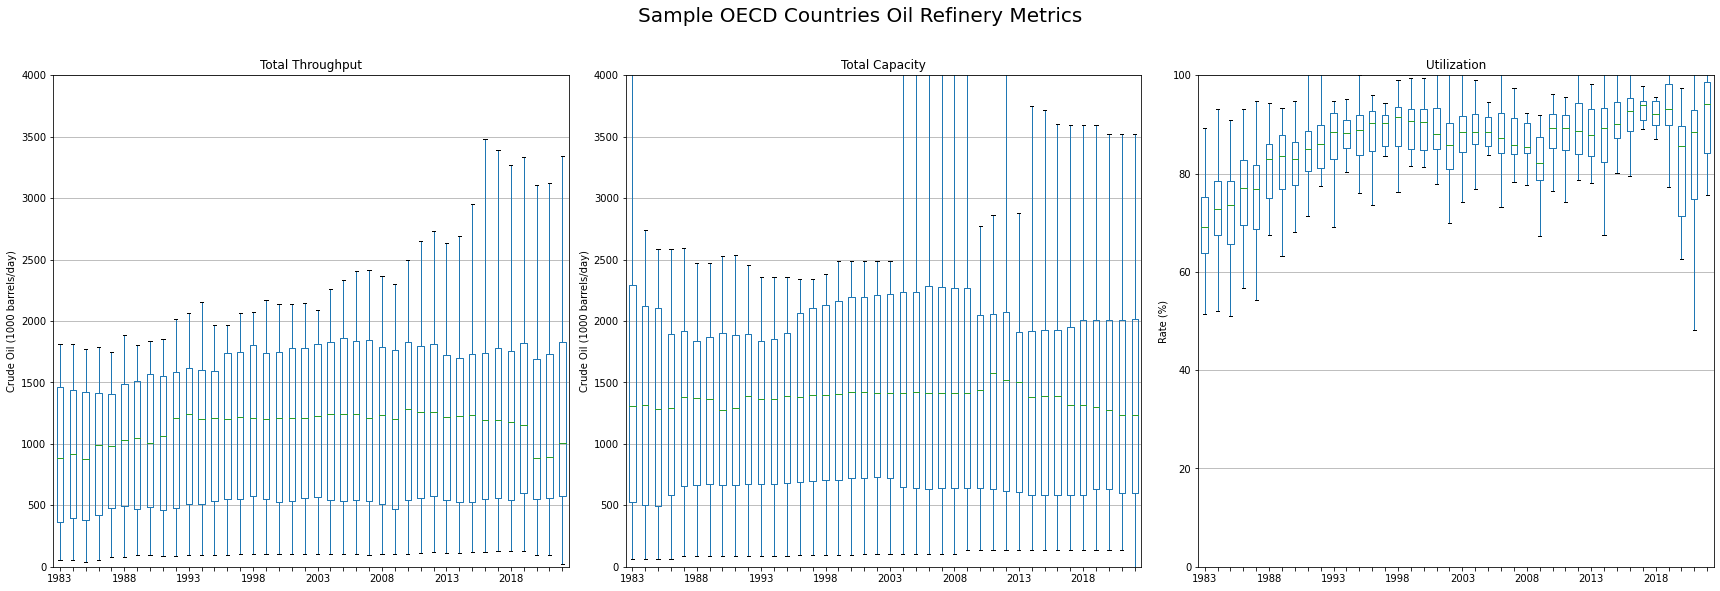

In [59]:
oecd_sample_countries = oecd_countries[oecd_countries.isin(refinery_utilization_df.columns)]
box_plot_refinery(oecd_sample_countries, title="Sample OECD Countries Oil Refinery Metrics")

OPEC Countries have more variance is their utilization of oil refineries then OECD countries. A factor of this could be the fact that OPEC sets production quotas for member countries, forcing members to not produce and use oil refineries at the most optimal domestic rate.   

## Crude Oil Spot Prices

### Extract, Transform, and Load (ETL) Data

This imports crude oil spot prices for countries world wide (including all OPEC members) from 1983 to 2022. The **Spot Price** is the current market equilibrium of a future contract; this is used to determine the current price a future contracts, which is how oil is traded. 

In [60]:
# Importing oil spot price dataset. 
oil_spot_prices_df = pd.read_csv("data/opec_prices/oil_spot_prices.csv", index_col="Index")
oil_spot_prices_df.replace('na', np.nan, inplace=True)
oil_spot_prices_df = oil_spot_prices_df.astype(float)

# Creating 2D index for countries with multiple oil benchmarks.  
oil_spot_prices_df.index = oil_spot_prices_df.index.str.split(' - ', expand=True)

# Replacing incorrectly labeled countries. 
oil_spot_prices_df = oil_spot_prices_df.rename(index={'IR Iran': 'I.R.Iran'})

# Transposing DataFrames to set years as index.  
oil_spot_prices_df = oil_spot_prices_df.transpose()

# Display.
oil_spot_prices_df.head()

Algeria  Angola    Egypt   I.R.Iran Indonesia   Libya Malaysia        \
     Zarzaitine Cabinda Suez Mix Iran Light     Minas   Brega     Miri Tapis   
1983     30.398     NaN      NaN     28.145    28.981  29.740      NaN   NaN   
1984     29.087     NaN   27.197     26.810    27.962  28.879      NaN   NaN   
1985     27.925     NaN   25.870     26.034    25.990  27.789      NaN   NaN   
1986     14.832     NaN   12.619     13.501    13.415  14.313      NaN   NaN   
1987     18.095     NaN   16.748     17.027    17.779  17.675      NaN   NaN   

      Mexico          ...  Norway    Oman   Qatar  Russia Saudi Arabia  \
     Isthmus    Maya  ... Oseberg    Oman  Dukhan   Urals   Arab Heavy   
1983  28.817     NaN  ...     NaN  28.748  29.122     NaN       26.590   
1984  28.192     NaN  ...     NaN  28.019  28.018     NaN       26.681   
1985  26.858     NaN  ...     NaN  26.944  27.150     NaN       25.833   
1986  13.433     NaN  ...     NaN  13.288  13.458     NaN          NaN   
1987  17.809  15.261  ...     NaN  17.252  17.395  17.289       16.083   

     United Kingdom         United States United Arab Emirates    OPEC  
         BrentDated Forties           WTI                Dubai     ORB  
1983         29.715  29.572        30.413               28.180  29.037  
1984         28.715  28.586        29.393               27.522  28.204  
1985         27.533  27.472        27.960               26.491  27.007  
1986         14.274  14.182        14.913               12.956  13.533  
1987         18.406  18.270        19.164               16.916  17.725  

[5 rows x 22 columns]

### Exploratory Data Analysis (EDA)

Oil spot prices are categorized by country and benchmark, such that countries can have multiple benchmarks or tack each others. Too analize how spot price benchmarks vary from each other, I normalize the spot prices using the **Z-Score** then compute a **5-year moving average**. This is done for OPEC and OECD countries where spot price data was available. 

In [61]:
# Function plots the spot prices of oil, z-score dist. of spot prices and the 10 year moving average of z-score dist. for given list of countries. 
def line_plot_price(cols, title):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

    oil_spot_prices_df[cols].plot(kind='line', legend=False, ax=ax1)
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Crude Oil (1000 barrels/day)')
    ax1.set_title('Spot Prices')
    ax3.axhline(y=0, color='black', linestyle='--')

    # Computing the z-score
    oil_spot_prices_norm = oil_spot_prices_df[cols].apply(zscore, axis=1)

    oil_spot_prices_norm.plot(kind='line', legend=False, ax=ax2)
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Spot Price (Z-Score)')
    ax2.set_title('Normalized Spot Prices')
    ax3.axhline(y=0, color='black', linestyle='--')

    # Computing moving average for normalized spot prices.   
    oil_spot_prices_ma = oil_spot_prices_norm.rolling(window=5, min_periods=5).mean()

    oil_spot_prices_ma.plot(kind='line', legend=False, ax=ax3)
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Spot Price (Z-Score)')
    ax3.set_title('Normalized 5-Year Moving Average Spot Prices ')
    ax3.axhline(y=0, color='black', linestyle='--')

    lines, labels = ax1.get_legend_handles_labels()
    fig.legend(lines, labels, loc='center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    fig.suptitle(title, fontsize=20, y=1.02)
    plt.tight_layout()
    

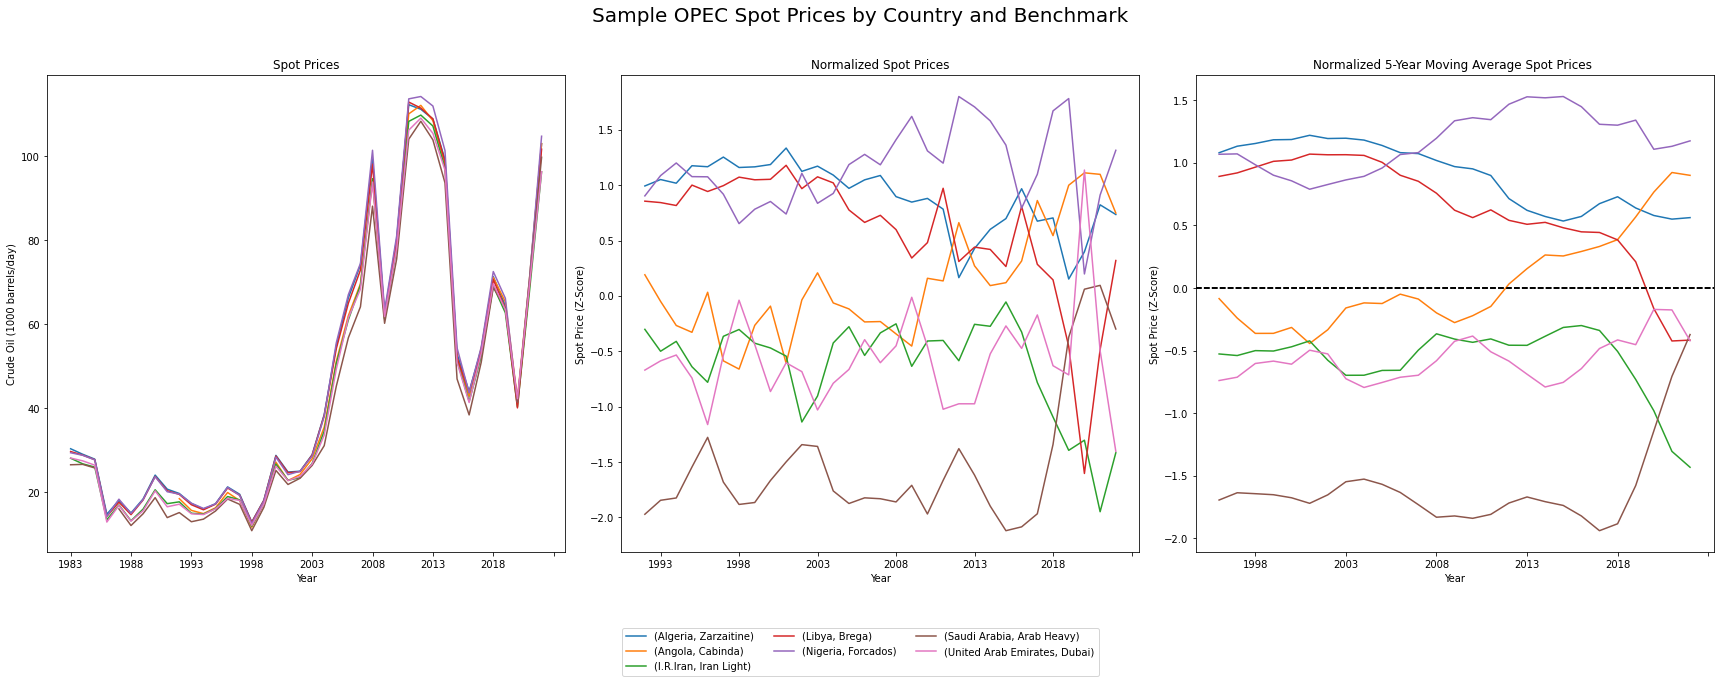

In [62]:
oil_spot_prices_countries = tuple(zip(*oil_spot_prices_df))[0]
opec_sample_countries = opec_countries[opec_countries.isin(oil_spot_prices_countries)]
line_plot_price(opec_sample_countries, "Sample OPEC Spot Prices by Country and Benchmark")

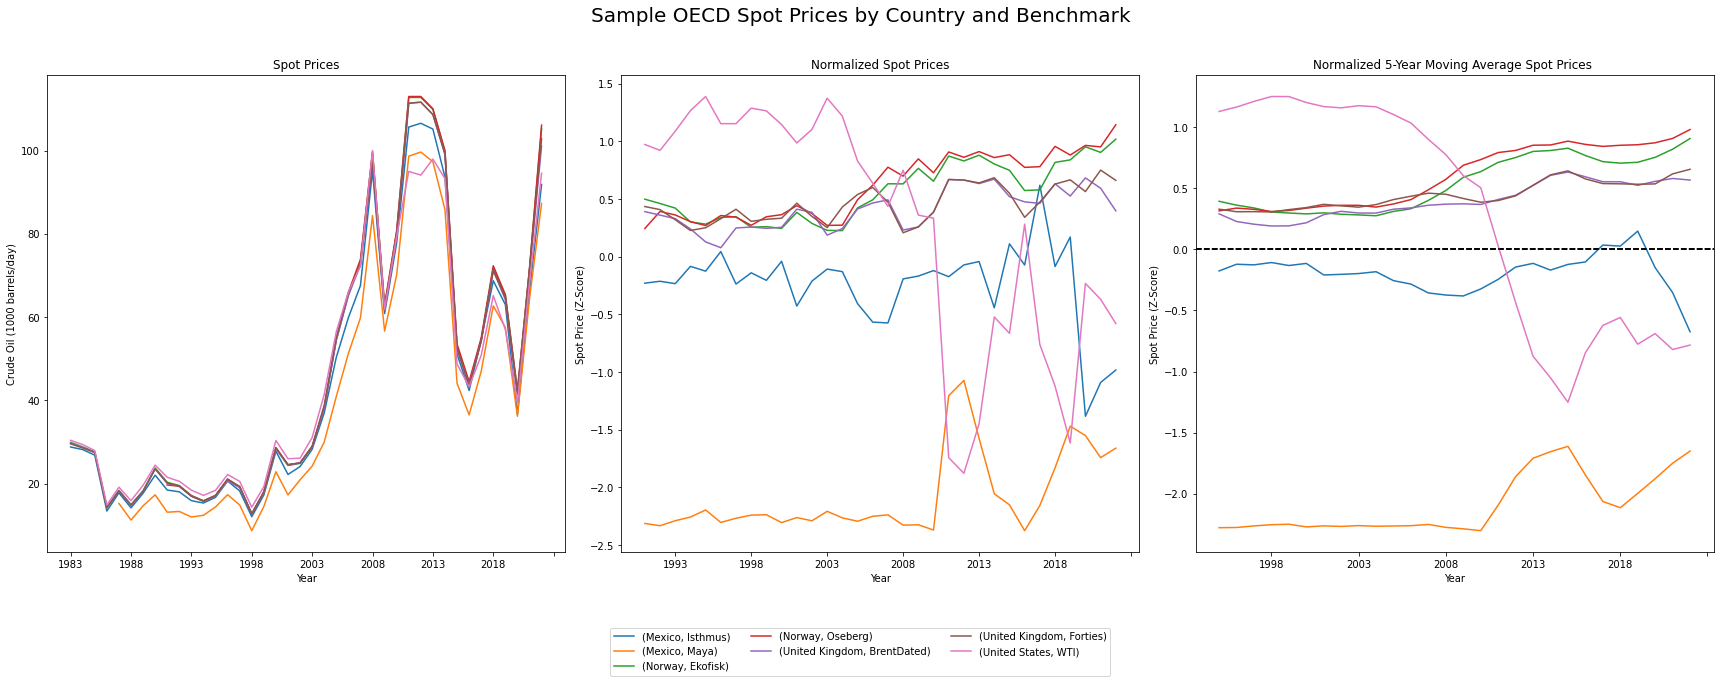

In [65]:
oecd_sample_countries = oecd_countries[oecd_countries.isin(oil_spot_prices_countries)]
line_plot_price(oecd_sample_countries, "Sample OECD Spot Prices by Country and Benchmark")

Observations from the spot price visualizations: 
- Saudi Heavy oil trades as a discount relative to all OPEC countries. 
- WIT oil became relatively cheaper then other OECD countries between 2003 and 2013. 
- The United Kingdoms Brent and Forties benchmarks trade at a tight spread from eachother. A factor of this is because Brent is a composite of the Forties benchmark. 

## Model Proposals

### First: Linear Regression of Spot Price

Consideration about OPEC countries based on EDA: 
- All counties produce a **net surplus** of crude oil. 
- All counties **do not** set their own production quotas. 
- All counties **do not** have an 100% utilization rate for domestic oil refineries.  

In [20]:
# converting python notebook to html
!jupyter nbconvert --to html milestone_2.ipynb --output index

[NbConvertApp] Converting notebook milestone_2.ipynb to html
[NbConvertApp] Writing 1508744 bytes to index.html
